In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

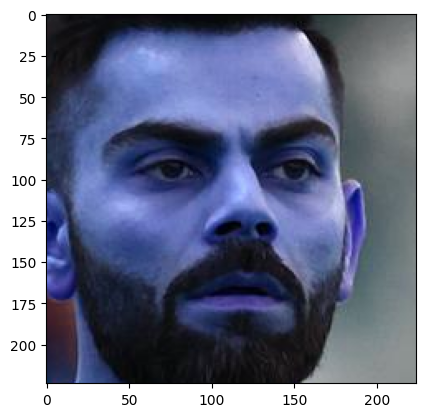

In [2]:
cropped_img = cv2.imread('./cropped_dataset/virat_kohli/virat_kohli-1.png')
plt.imshow(cropped_img, cmap='gray')

# Preprocessing: Use wavelet transform as a feature for traning our model
In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

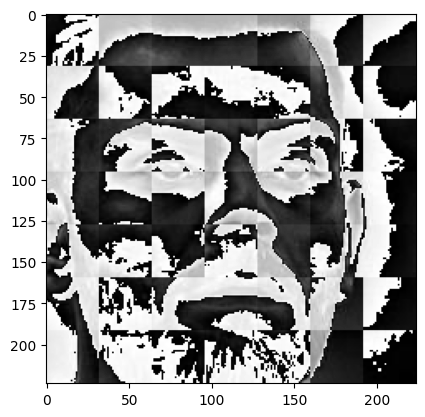

In [3]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    
    
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    
    #Process Coefficients
    coeffs_H=list(coeffs)  
    
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
    # plt.imshow(imArray_H    , cmap='gray')

    return imArray_H


im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

In [4]:
import os 
folder_dirs = []
for entry in os.scandir('./cropped_dataset/'):
    if entry.is_dir():
        folder_dirs.append(entry.path)
        
print(folder_dirs)

['./cropped_dataset/Cristiano_Ronaldo', './cropped_dataset/ms_dhoni', './cropped_dataset/virat_kohli']


In [18]:
celeb_dic = {}
X, y = [], []
count = 1 

for folder_dir in folder_dirs:
    celeb_name =  folder_dir.split('/')[-1]
    celeb_dic[count] = celeb_name 
    
    for img_dir in os.scandir(folder_dir):
        
                img = cv2.imread(img_dir.path)
                img_har = w2d(img,'db1',5)
                
                scalled_raw_img = cv2.resize(img, (32, 32))
                scalled_har_img = cv2.resize(img_har, (32, 32))
                
                
                
                combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_har_img.reshape(32*32 , 1)))
                # 32 * 32 * 3 + 32 * 32
                
                
                
                # plt.imshow(combined_img)
                # print(img.shape , img_har.shape , scalled_raw_img.shape , scalled_har_img.shape , combined_img.shape) 
                
                X.append(combined_img)
                y.append(count)
                
    count+=1     
     
    

In [ ]:
celeb_dic

{1: 'Cristiano_Ronaldo', 2: 'ms_dhoni', 3: 'virat_kohli'}

In [ ]:
X[0].shape

(4096, 1)

In [ ]:
len(X) , len(X[0])

(92, 4096)

In [ ]:
32*32*3 + 32*32

4096

In [21]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(92, 4096)

# Train module

In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9130434782608695

In [23]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           1       0.93      1.00      0.96        13
           2       1.00      0.75      0.86         4
           3       0.83      0.83      0.83         6

    accuracy                           0.91        23
   macro avg       0.92      0.86      0.88        23
weighted avg       0.92      0.91      0.91        23



In [ ]:
# Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [24]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [25]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [26]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


,model,best_score,best_params
0,svm,0.839560,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.738462,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.839560,{'logisticregression__C': 1}


In [ ]:
best_clf = best_estimators['svm']

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[13,  0,  0],
       [ 0,  4,  0],
       [ 0,  1,  5]], dtype=int64)

In [ ]:
celeb_dic

{1: 'Cristiano_Ronaldo', 2: 'ms_dhoni', 3: 'virat_kohli'}

In [28]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

NameError: name 'cm' is not defined

<Figure size 1000x700 with 0 Axes>

In [27]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(celeb_dic))

NameError: name 'best_clf' is not defined